In [3]:
import warnings
import logging
warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Analise de Swagger (OpenAPI Specification) with LDA + WordNet

## 1. Importando Arquivos e Parse do Formato

Verificando se o arquivo está no formato adequado, caso não esteja é descartado

In [4]:
from prance import ResolvingParser, ValidationError
import json, os
dataFolder = "dados"
dataFolderValidados = "dados_validos"
listSwagger = []
count = 0
countReadFiles = 0
countGenericErros = 0
countInvalidFormat = 0
for fileName in os.listdir(dataFolder):
    countReadFiles += 1
    try:
        parser = ResolvingParser(os.path.join(dataFolder,fileName),backend = 'openapi-spec-validator')
        swaggerJson = parser.json()
        listSwagger.append(swaggerJson)
        count += 1
        with open(os.path.join(dataFolderValidados,fileName),"w", encoding='utf-8') as file:
            file.write(swaggerJson)
    except ValidationError:
        countInvalidFormat += 1 
    except Exception:
        countGenericErros += 1
    print("\r",end="")
    print(f"file:{count}/{countReadFiles}",end="")

print(f"\nCorpusSize:{count} ReadFiles:{countReadFiles} InvalidFiles:{countInvalidFormat} GenericErros:{countGenericErros}")

file:15800/20008
CorpusSize:15800 ReadFiles:20008 InvalidFiles:2683 GenericErros:1525


## 2. Gerando o Corpus - Seleção dos atributos do arquivo

In [21]:
docs = []

for i in range(len(listSwagger)):
    try:
        swagger = json.loads(listSwagger[i])
        doc = ""
        doc+= f"{i}\n" # indice do documento
        doc+= swagger['info']['title'] + '\n' # titulo
        #doc+= "DESCRIPTION: " + (swagger['info']['description'] if 'description' in swagger['info'] else "") + "\n" # descricao
        '''
        for path in swagger['paths']:
            doc+= "OPERATION: " + path + "\n"
            doc+= "OPERATION DESCRIPTION: "
            for ope in swagger['paths'][path]:
                if 'description' in swagger['paths'][path][ope]:
                    doc+= swagger['paths'][path][ope]['description']+"; "
            doc+= "\n"
            doc+="RESPONSE DESCRIPTION: "
            for ope in swagger['paths'][path]:
                if 'responses' in swagger['paths'][path][ope]:
                    for code in swagger['paths'][path][ope]['responses']:
                        doc+= swagger['paths'][path][ope]['responses'][code]['description']+"; "
            doc+= "\n"
        '''
        docs.append(doc)
    except KeyError as e:
        print(f"{i} - KeyError:{e}")

In [22]:
print(docs[0])

0
Simple Inventory API



## 3. Tokenizando o documento

In [23]:
import re
from nltk.tokenize import RegexpTokenizer
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

# Remove distracting single quotes
docs = [[re.sub("\'", "", token) for token in doc] for doc in docs]

stopWords = stopwords.words('english')
stopWords.extend(['api','apis','www','http','com','app','use','swagger'])
# Remove StopWords
docs = [[word for word in simple_preprocess(str(doc)) if word not in stopWords] for doc in docs]


In [24]:
print(docs[0])

['simple', 'inventory']


## 4. Lamatizatizando utilizando Wordnet

In [25]:
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [26]:
print(docs[0])

['simple', 'inventory']


## 5. Computando o Bigramas

In [27]:
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

2020-12-14 20:30:15,120 : INFO : collecting all words and their counts
2020-12-14 20:30:15,127 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-12-14 20:30:15,231 : INFO : PROGRESS: at sentence #10000, processed 18701 words and 12474 word types
2020-12-14 20:30:15,300 : INFO : collected 18520 word types from a corpus of 29528 words (unigram + bigrams) and 15800 sentences
2020-12-14 20:30:15,306 : INFO : using 18520 counts as vocab in Phrases<0 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>


In [28]:
print(docs[0])

['simple', 'inventory']


## 6. Removendo os tokens comuns e raros

In [29]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

2020-12-14 20:30:16,250 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-12-14 20:30:16,485 : INFO : adding document #10000 to Dictionary(6309 unique tokens: ['inventory', 'simple', 'ach', 'central', 'da']...)
2020-12-14 20:30:16,666 : INFO : built Dictionary(9125 unique tokens: ['inventory', 'simple', 'ach', 'central', 'da']...) from 15800 documents (total 30441 corpus positions)
2020-12-14 20:30:16,712 : INFO : discarding 9005 tokens: [('ach', 1), ('central', 10), ('da', 17), ('simulação', 1), ('sistema', 6), ('智掌柜开放api', 1), ('zeuz', 1), ('zxpense', 1), ('bcx', 2), ('pillar', 3)]...
2020-12-14 20:30:16,715 : INFO : keeping 120 tokens which were in no less than 20 and no more than 7900 (=50.0%) documents
2020-12-14 20:30:16,730 : INFO : resulting dictionary: Dictionary(120 unique tokens: ['inventory', 'simple', 'external', 'gateway', 'backend']...)


## 7. Vetorizando os documentos e computando a frequencia de cada palavra

In [30]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [31]:
print(corpus)

(1, 1)], [], [(67, 1)], [(6, 1)], [], [], [(21, 1), (22, 1), (23, 1)], [(15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (91, 1), (92, 1)], [], [], [(0, 1), (1, 1)], [(72, 1)], [(19, 1)], [(15, 1), (16, 1), (18, 1), (19, 1), (32, 1), (33, 1), (34, 1)], [], [], [], [(48, 1)], [], [], [], [], [], [(0, 1), (1, 1)], [], [], [(5, 1)], [], [], [], [], [(11, 1), (30, 1)], [(11, 1)], [], [(49, 1)], [(4, 1)], [(0, 1), (1, 1)], [], [(0, 1), (1, 1)], [(113, 1)], [(36, 1)], [(0, 1), (1, 1)], [], [(86, 1)], [(0, 1), (1, 1)], [], [], [], [], [(5, 1)], [(45, 1)], [(74, 1)], [], [], [(5, 1)], [], [], [], [], [], [], [(11, 1)], [(12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)], [(12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)], [(12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)], [], [(12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)], [], [], [(40, 1)], [], [], [(5, 1)], [], [(4, 1)]

## 8. Verificando quantos tokens foram gerados

In [32]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 120
Number of documents: 15800


## 9. Habilitando os Log

# LDA Treining Model

## 10 - LDA

In [33]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

2000 documents with 1690 words
2020-12-14 20:34:03,857 : INFO : PROGRESS: pass 18, at document #10000/15800
2020-12-14 20:34:04,721 : INFO : optimized alpha [0.07610115, 0.06844047, 0.21744157, 0.04067897, 0.23830535, 0.10600792, 0.0623195, 0.0647398, 0.052652244, 0.06425719]
2020-12-14 20:34:04,723 : INFO : merging changes from 2000 documents into a model of 15800 documents
2020-12-14 20:34:04,725 : INFO : topic #3 (0.041): 0.273*"music" + 0.173*"portal" + 0.165*"open" + 0.112*"hub" + 0.095*"transaction" + 0.077*"id" + 0.068*"mock" + 0.000*"get" + 0.000*"request" + 0.000*"account"
2020-12-14 20:34:04,732 : INFO : topic #8 (0.053): 0.315*"data" + 0.252*"web" + 0.092*"platform" + 0.090*"partner" + 0.062*"employee" + 0.052*"delivery" + 0.050*"io" + 0.038*"restful" + 0.030*"tracking" + 0.000*"request"
2020-12-14 20:34:04,751 : INFO : topic #5 (0.106): 0.274*"service" + 0.089*"application" + 0.071*"flow" + 0.070*"oauth" + 0.068*"sample" + 0.067*"project" + 0.066*"sample_application" + 0.06

In [34]:
#View Top Topic
from pprint import pprint

top_topics = model.top_topics(corpus) #, num_words=20)

pprint(top_topics)

2020-12-14 20:34:21,473 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2020-12-14 20:34:21,485 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2020-12-14 20:34:21,491 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2020-12-14 20:34:21,503 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2020-12-14 20:34:21,516 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2020-12-14 20:34:21,523 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2020-12-14 20:34:21,535 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2020-12-14 20:34:21,549 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2020-12-14 20:34:21,564 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2020-12-14 20:34:21,574 : INFO : CorpusAccumulator accumulated stats from 10000 documents
2020-12-14 20:34:21,588 : INFO : CorpusAccumulator accumulated stats from 11000 documents
2020-12-14 20:34:21

## Dominant topic and its percentage contribution in each document

In [35]:
import pandas as  pd
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=model, corpus=corpus, texts=docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.7500,"simple, inventory, account, get, endpoint, doc...","[simple, inventory]"
1,1,4.0,0.7500,"simple, inventory, account, get, endpoint, doc...","[simple, inventory]"
2,2,4.0,0.2427,"simple, inventory, account, get, endpoint, doc...","[sistema, central, da, simulação, ach]"
3,3,4.0,0.7500,"simple, inventory, account, get, endpoint, doc...","[simple, inventory]"
4,4,4.0,0.2427,"simple, inventory, account, get, endpoint, doc...",[智掌柜开放api]
5,5,2.0,0.6127,"petstore, integration, system, manager, specif...","[zeuz, external]"
6,6,1.0,0.5377,"rest, de, gateway, document, client, core, inf...","[zxpense, gateway]"
7,7,4.0,0.7500,"simple, inventory, account, get, endpoint, doc...","[simple, inventory]"
8,8,4.0,0.2427,"simple, inventory, account, get, endpoint, doc...",[]
9,9,9.0,0.5357,"test, documentation, public, backend, dev, clo...","[pillar, bcx, backend]"


## Avaliação do Modelo

In [36]:
from gensim.models import CoherenceModel

# Compute Perplexity
print('\nPerplexity: ', model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

# Compute Coherence Score
coherence_model = CoherenceModel(model=model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2020-12-14 20:37:27,157 : INFO : -3.438 per-word bound, 10.8 perplexity estimate based on a held-out corpus of 15800 documents with 14828 words
2020-12-14 20:37:27,173 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows

Perplexity:  -3.437967630084639
Average topic coherence: -17.9288.
2020-12-14 20:37:34,693 : INFO : 3 accumulators retrieved from output queue
2020-12-14 20:37:34,755 : INFO : accumulated word occurrence stats for 9324 virtual documents

Coherence Score:  0.623223846152021


# Visualização do Modelo

## A Sentença mais representativa para cada tópico

In [39]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

c:\Users\fialho\Desktop\py_extract_swagger\.venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8174,"defaulttitle, order, customer, search, store, title, event, po, game, auth","[yahoo, small, business, update, new, custom, order, status]"
1,1.0,0.7697,"rest, de, gateway, document, client, core, information, bank, ai, lead","[servicio, de, guardado, de, preferencias, de, usuario]"
2,2.0,0.8071,"petstore, integration, system, manager, specification, online, sampleapi, login, book, openapi","[online, enrolment, system, specification]"
3,3.0,0.5235,"music, open, portal, id, transaction, hub, mock, get, account, specification","[woot, developer, portal]"
4,4.0,0.7500,"simple, inventory, account, get, endpoint, doc, para, sm, request, message","[simple, inventory]"
5,5.0,0.8898,"service, application, oauth, flow, sample, project, sample_application, flow_oauth, user, mobile","[sample, application, flow, oauth, project, sample_application, flow_oauth]"
6,6.0,0.8842,"sample, iot, home, home_iot, password, project, sample_password, flow_oauth, oauth, flow","[sample, password, flow, oauth, project, sample_password, flow_oauth]"
7,7.0,0.9077,"project, oauth, flow, management, oauth_project, sample, access, code, payment, product","[sample, access, code, flow, oauth, project, sample_access, code_flow, oauth_project]"
8,8.0,0.6872,"data, web, platform, partner, restful, employee, io, tracking, delivery, sm","[colorado, matf, data, trust, data, resource]"
9,9.0,0.6912,"test, documentation, public, backend, dev, cloud, example, transfer, request, sm","[front, end, dev, test]"


## Frequencia de Distribuição do Total de Palavras nos Documentos

c:\Users\fialho\Desktop\py_extract_swagger\.venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Python38\lib\asyncio\events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


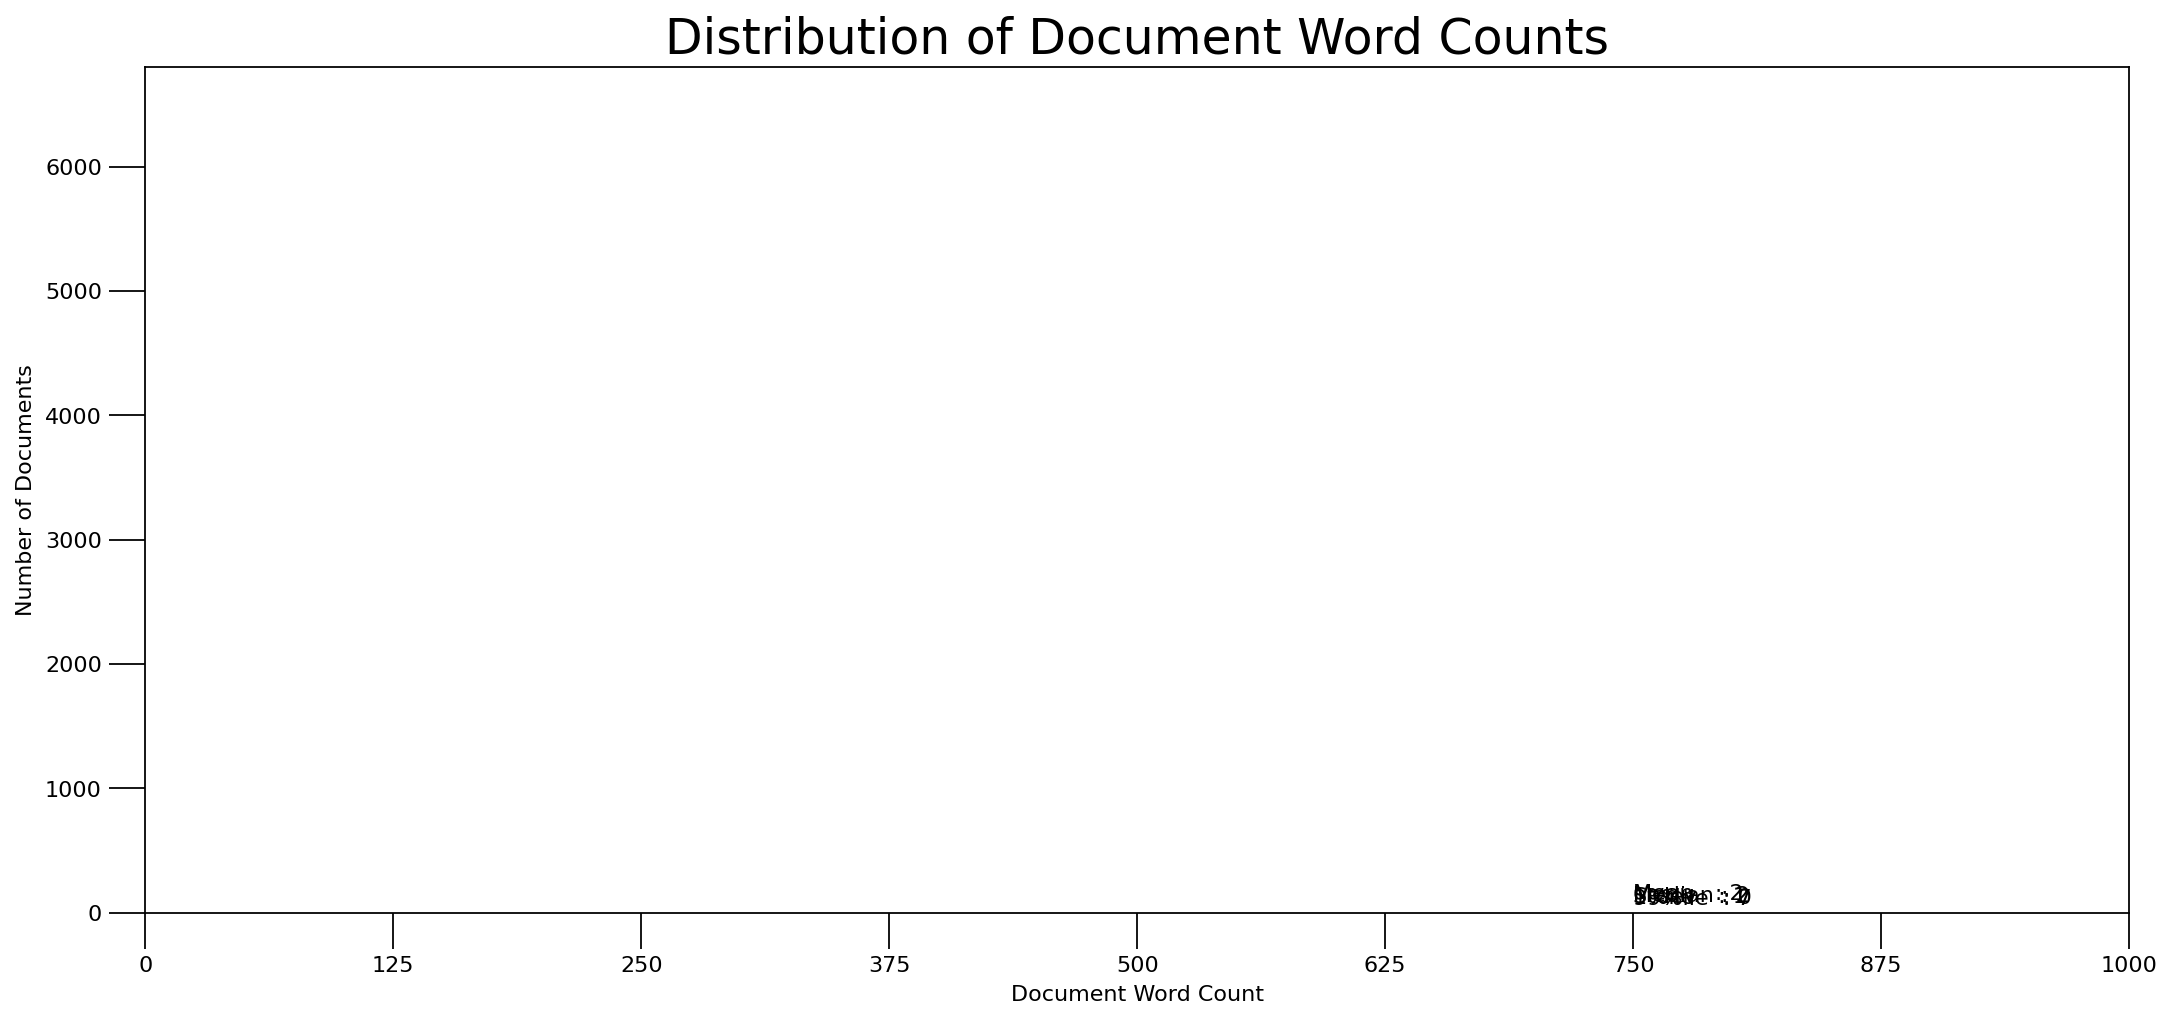

In [41]:
import matplotlib.pyplot as plt
import re, numpy as np
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

## Distribuição de quantidade de documentos por Topico dominantes

c:\Users\fialho\Desktop\py_extract_swagger\.venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Python38\lib\asyncio\events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


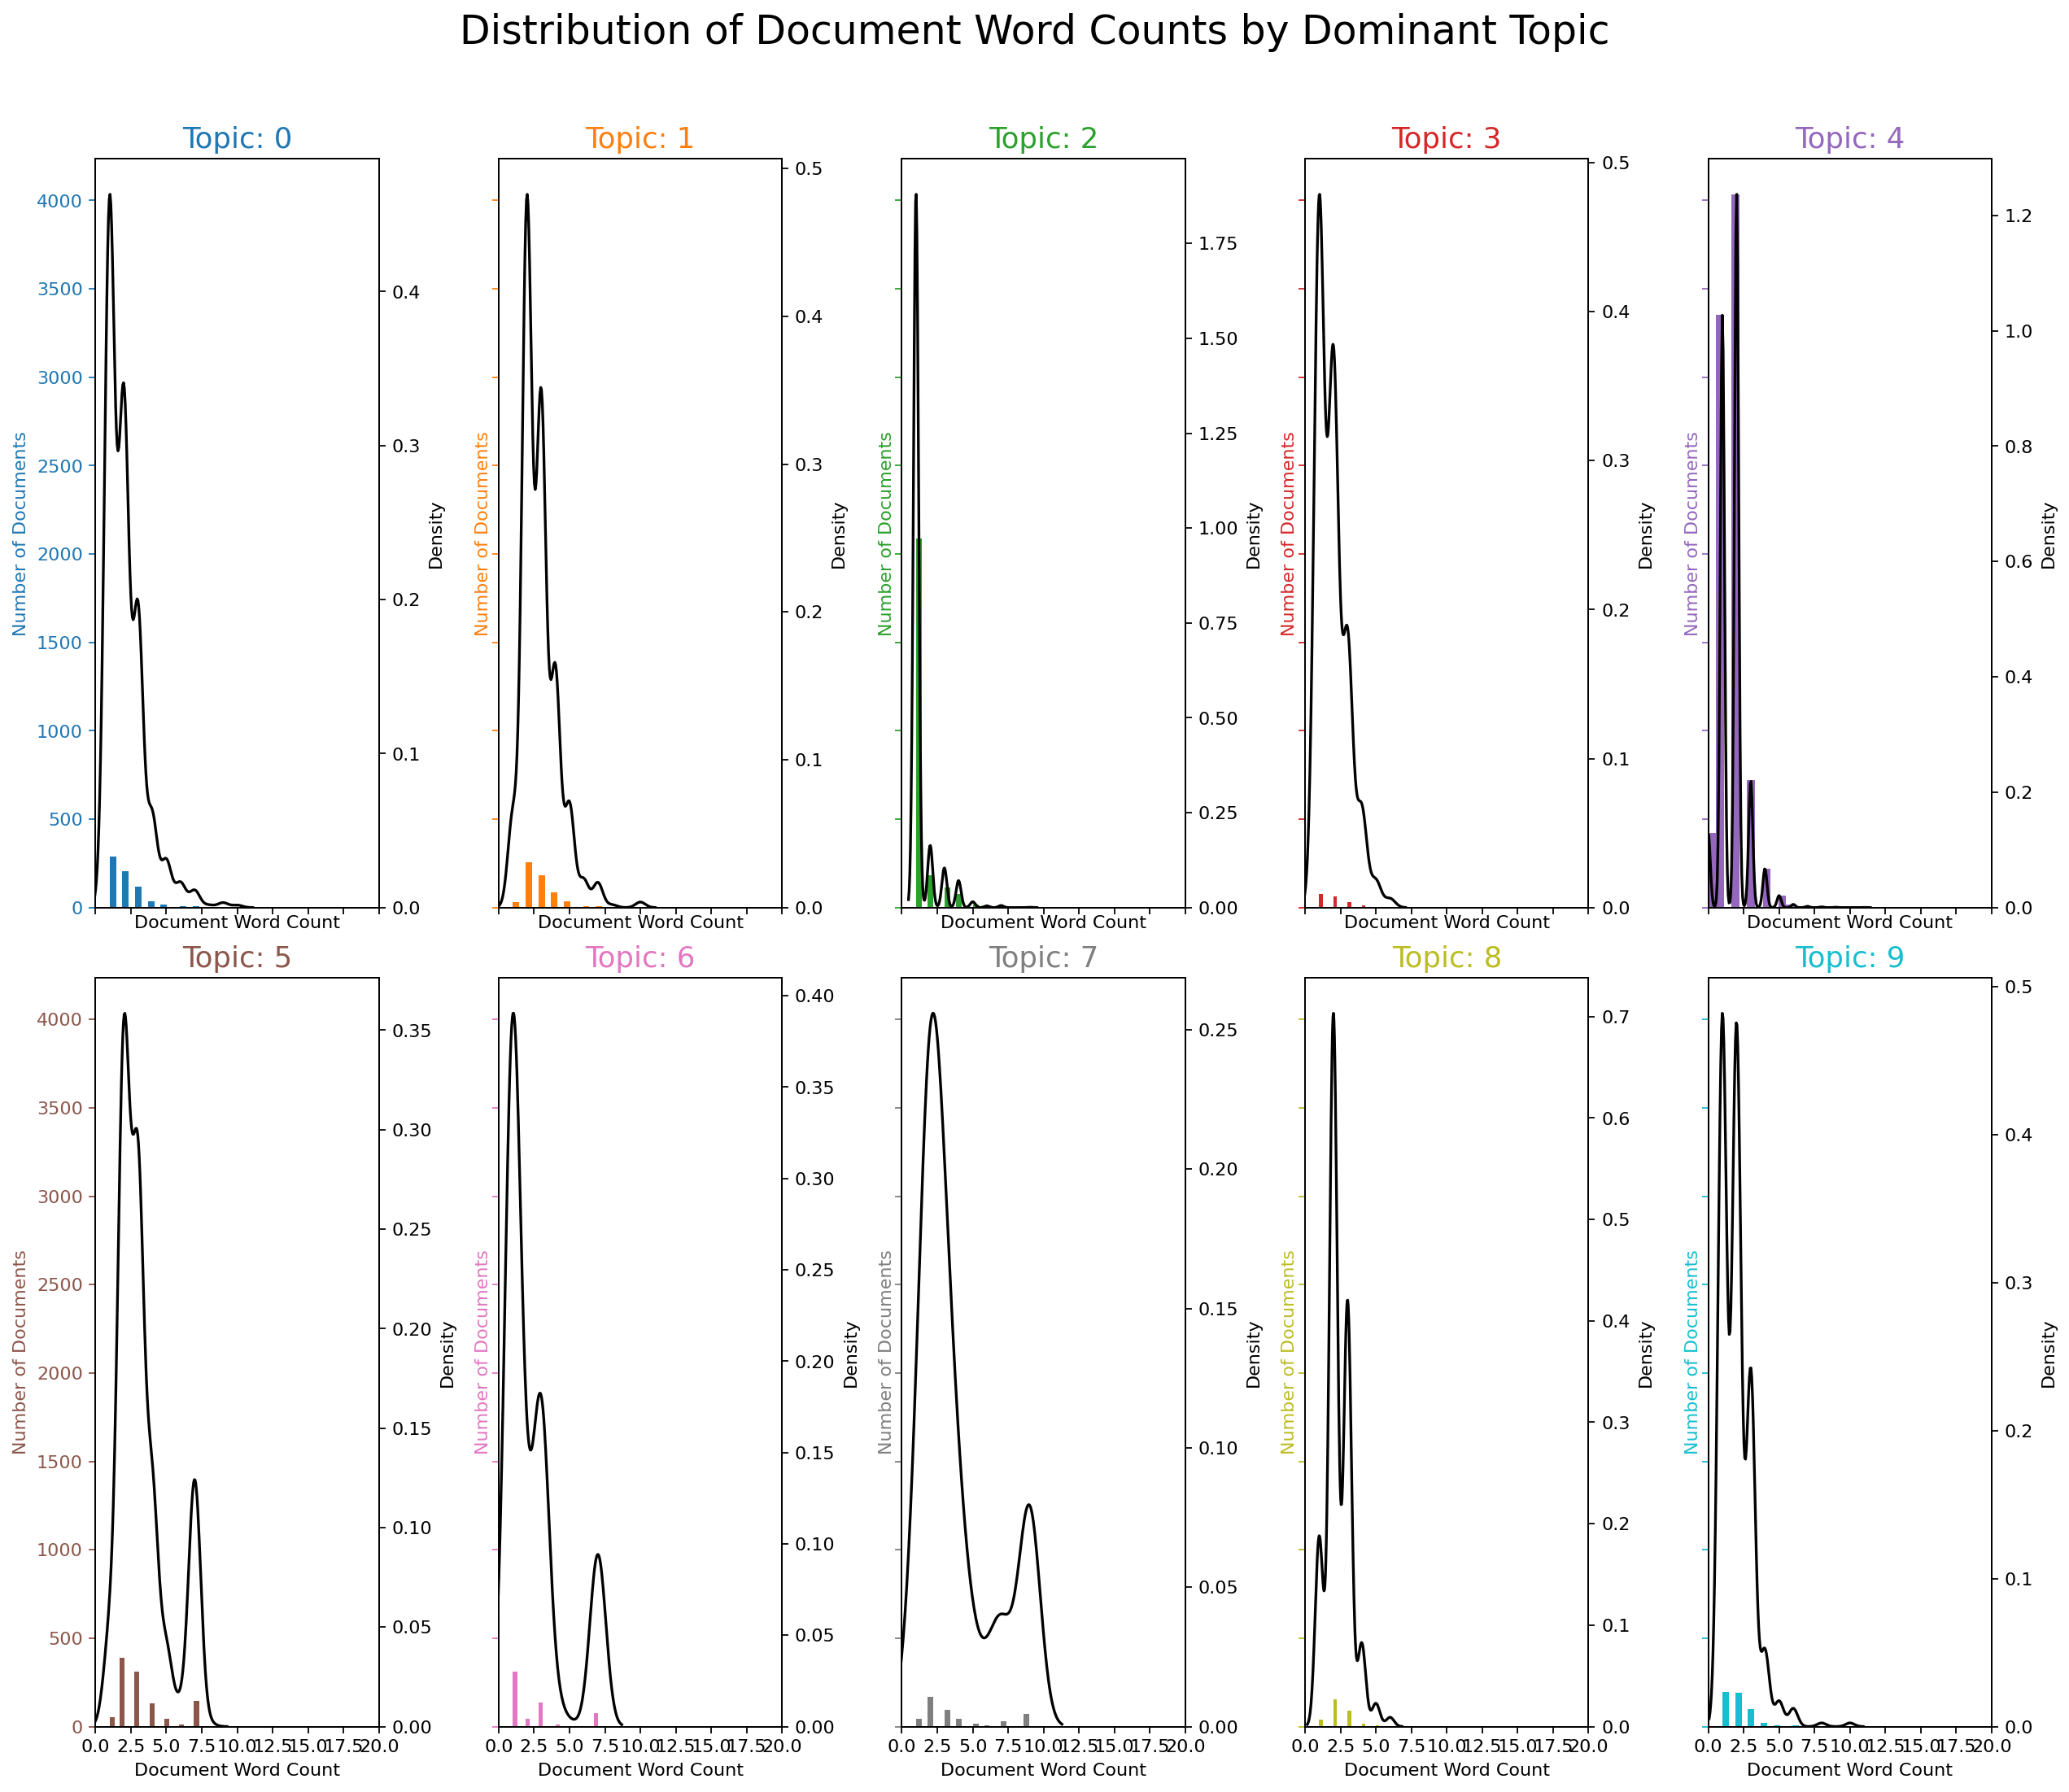

In [58]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,5,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 20, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 20), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,20,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

## Word Cloud

c:\Users\fialho\Desktop\py_extract_swagger\.venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Python38\lib\asyncio\events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


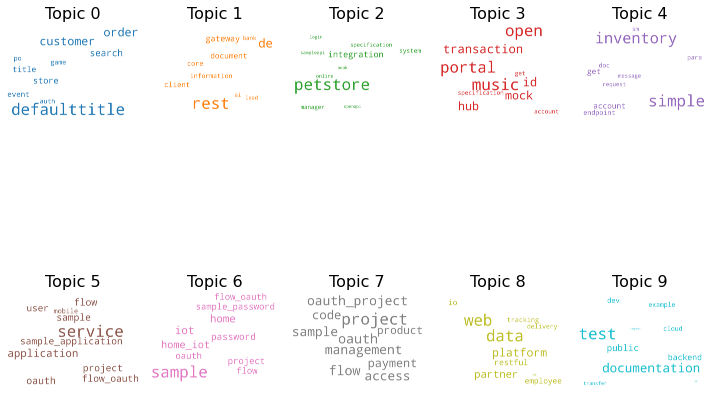

In [48]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopWords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Quantidade de palavras por Topic KeyWords

c:\Users\fialho\Desktop\py_extract_swagger\.venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Python38\lib\asyncio\events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


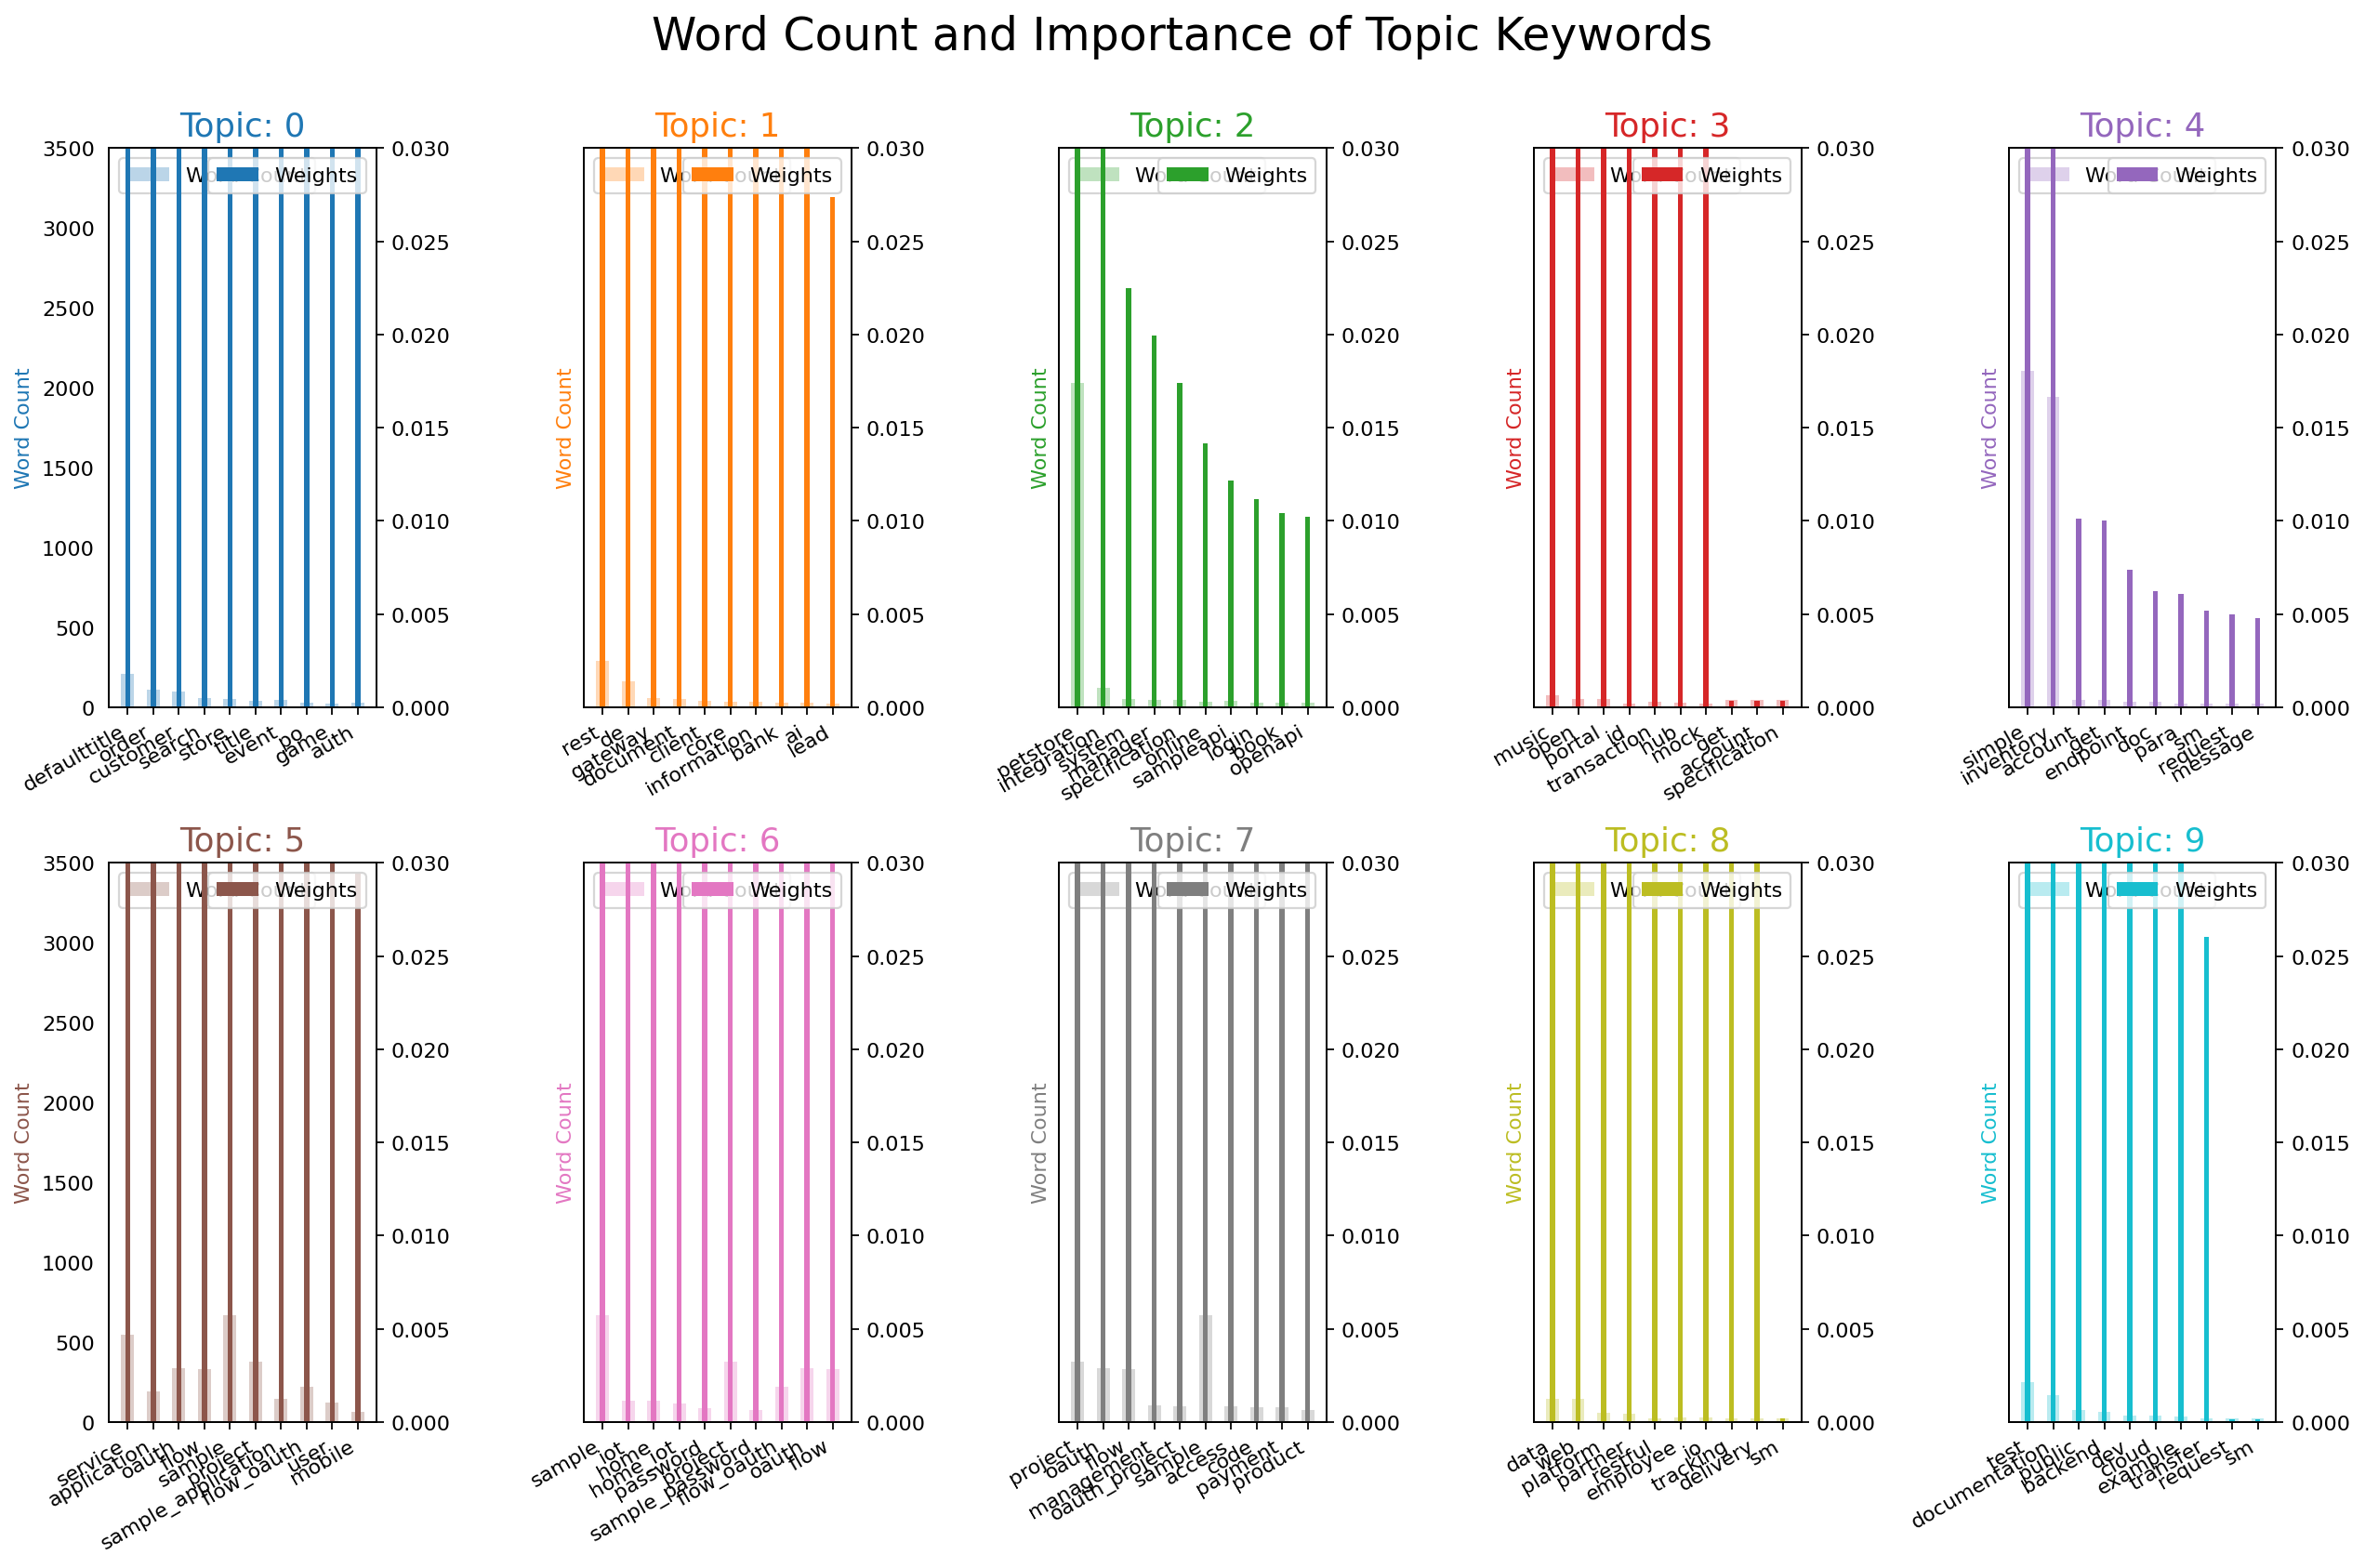

In [51]:
from collections import Counter
topics = model.show_topics(formatted=False)
data_flat = [w for w_list in docs for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 5, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [37]:
import pyLDAvis
import pyLDAvis.gensim
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

2020-12-14 20:37:41,071 : INFO : NumExpr defaulting to 4 threads.


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.140918 -0.432459       1        1  27.768982
2     -0.141704 -0.055086       2        1  16.706172
5      0.313210 -0.003933       3        1  14.230742
7      0.296773 -0.000851       4        1   9.638287
6      0.325584 -0.006546       5        1   8.727026
0     -0.137323  0.121947       6        1   6.091265
1     -0.134965  0.094946       7        1   5.488543
9     -0.133059  0.076510       8        1   4.903972
8     -0.129640  0.098700       9        1   3.906749
3     -0.117958  0.106773      10        1   2.538261, topic_info=         Term         Freq        Total Category  logprob  loglift
5    petstore  1958.000000  1958.000000  Default  30.0000  30.0000
1      simple  2021.000000  2021.000000  Default  29.0000  29.0000
0   inventory  1862.000000  1862.000000  Default  28.0000  28.0000
27    service   525.000000   525.000000  Default  27.0000  27.0000
36       rest   303.000000   303.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
53     client     0.136895    43.677192  Topic10  -7.9191  -2.0917
12     access     0.136895   100.989193  Topic10  -7.9191  -2.9299
18    project     0.136895   392.026014  Topic10  -7.9191  -4.2862
39     status     0.136895    28.001064  Topic10  -7.9191  -1.6471
64  interface     0.136894    28.982014  Topic10  -7.9191  -1.6815

[465 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
12        4  0.990205       access
69        1  0.985686      account
77        3  0.970197        admin
57        7  0.976712           ai
32        3  0.997075  application
...     ...       ...          ...
95        9  0.947895     tracking
43       10  0.980408  transaction
99        8  0.957106     transfer
52        3  0.992821         user
68        9  0.992888          web

[129 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 6, 8, 7, 1, 2, 10, 9, 4])

# Salvar Modelo pre-treinado em disco

In [38]:
from gensim.test.utils import datapath
# Save model to disk.

temp_file = datapath("model")

model.save(temp_file)
# Load a potentially pretrained model from disk.
#lda = LdaModel.load(temp_file)

c:\Users\fialho\Desktop\py_extract_swagger\.venv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2020-12-14 20:37:52,709 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-12-14 20:37:52,713 : INFO : built Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...) from 9 documents (total 29 corpus positions)
2020-12-14 20:37:52,720 : INFO : saving LdaState object under c:\Users\fialho\Desktop\py_extract_swagger\.venv\lib\site-packages\gensim\test\test_data\model.state, separately None
2020-12-14 20:37:52,729 : INFO : saved c:\Users\fialho\Desktop\py_extract_swagger\.venv\lib\site-packages\gensim\test\test_data\model.state
2020-12-14 20:37:52,736 : INFO : savi